In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# def zero_padding(img, num_pad):
#     m, n = img.shape
#     img_pad = np.zeros((m + 2*num_pad, n + 2*num_pad))
#     img_pad[num_pad:-num_pad, num_pad:-num_pad] = img
#     return img_pad

In [4]:
def replicate_padding(img, num_pad):
    m, n = img.shape
    #   Tạo ma trận mới có kích thước tương ứng với padsize để lưu ảnh
    img_pad = np.zeros((m + 2*num_pad, n + 2*num_pad))
    
    #   Padding ở các viền
    img_pad[:num_pad, num_pad:n+num_pad] = img[0]
    img_pad[m+num_pad:, num_pad:n+num_pad] = img[m-1]
    img_pad[num_pad:m+num_pad, :num_pad] = img[:, 0].reshape(-1, 1)
    img_pad[num_pad:m+num_pad, m+num_pad:] = img[:,-1].reshape(-1, 1)

    #   Padding ở các góc
    img_pad[:num_pad, 0:num_pad] = img[0, 0]
    img_pad[:num_pad, n+num_pad:] = img[0, -1]
    img_pad[m+num_pad:, 0:num_pad] = img[m-1, 0]
    img_pad[m+num_pad:, n+num_pad:] = img[m-1, n-1]
    
    img_pad[num_pad:-num_pad, num_pad:-num_pad] = img
    return img_pad


In [5]:
def Conv2D(img, kernel):
    #   Getting shape of image
    m, n = img.shape
    #   Getting the size of one dimention of kernel
    ksize = kernel.shape[0]
    #   Getting replicate padding for image
    img_pad = replicate_padding(img, ksize//2)
    #   Creating zero matrix to save image after computing Cross Correlation operator
    new_img = np.zeros((m, n))
    
    #   Cross Correlation 
    for i in range(m):
        for j in range(n):
            temp = np.sum(kernel * img_pad[i:i+ksize, j:j+ksize])
            new_img[i][j] = temp
    return new_img

In [6]:
def gassian_filter(sigma, ksize):
    #   Creating zeros matrix to save gaussian filter
    gauss_filter = np.zeros((ksize, ksize), dtype = 'float')
    offset = ksize//2
    #   For..loop from index -ksize//2 to (ksize//2 + 1) coresponding 0 to size of filter 
    for i in range(-offset, offset + 1):
        for j in range(-offset, offset + 1):
            x1 = 2*np.pi*(sigma**2)
            x2 = np.exp(-(i**2 + j**2) / (2*(sigma**2)))
            #   Computing gaussian value for each pixel in filter
            gauss_filter[i + offset, j + offset] = (1/x1)*x2
    return gauss_filter

In [7]:
def convert_gray(img):
    if len(img.shape) > 2:
        #   Spliting image into 3 channels 
        B, G, R = img[:,:, 0], img[:,:, 1], img[:,:, 2]  
        #   Combining them together to generate gray image
        img_gray = 0.299*R + 0.587*G + 0.114*B
    return img_gray

In [8]:
def gauss_blur(img, sigma, ksize):
    #   Getting Gaussian filter
    gauss_filter = gassian_filter(sigma, ksize) 
    #   Using Cross Correlation operator to blur image
    img_blur = Conv2D(img, gauss_filter)
    return img_blur

In [9]:
def preprocessing(img, sigma, ksize):
    #   Convert image into float32 type
    img = img.astype(np.float32)
    #   Converting image to gray scale
    img_gray = convert_gray(img)
    #   Bluring image with gaussian filter
    img_blur = gauss_blur(img_gray, sigma, ksize)
    return img_blur

In [10]:
def compute_grad(img):
    #   Creating Sobel_X filter
    X_filter = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
    #   Creating Sobel_Y filter by transposing X_filter
    Y_filter = np.transpose(X_filter)
        
    Gx = Conv2D(img, X_filter)
    Gy = Conv2D(img, Y_filter)
    #   Getting absolute values of Gx and Gy
    Sobel_X = np.absolute(Gx)
    Sobel_Y = np.absolute(Gy)
    return Sobel_X, Sobel_Y

In [11]:
def window_summation(img, sigma, ksize):
    #   Gradient responding calculation
    Ix, Iy = compute_grad(img)

    #   Computing elements in M matrix
    Ix2 = np.square(Ix)
    Iy2 = np.square(Iy)
    IxIy = np.multiply(Ix, Iy)

    # M matrix summation (M = Gradient matrix convolute with Gaussian filter)
    Sum_Ix2 = Conv2D(Ix2, gassian_filter(sigma, ksize))
    Sum_Iy2 = Conv2D(Iy2, gassian_filter(sigma, ksize))
    Sum_IxIy = Conv2D(IxIy, gassian_filter(sigma, ksize))
    
    return Sum_Ix2, Sum_Iy2, Sum_IxIy

In [12]:
def Harris_Algorithm(M_elems, k, corner_threshold):
    Sum_Ix2, Sum_Iy2, Sum_IxIy = M_elems

    #   Computing Det and Trace of M matrix
    detM = np.multiply(Sum_Ix2, Sum_Iy2) - np.multiply(Sum_IxIy, Sum_IxIy)
    traceM = Sum_Ix2 + Sum_Iy2

    #   Computing R score.
    R = detM - k * np.square(traceM)

    #   Normalizing R
    norm_R = R / R.max()
    #   Setting all values in norm_R which smaller than corner_threshold equal to 0.
    norm_R[norm_R < corner_threshold] = 0
    return norm_R

In [13]:
def ShiTomasi_Algorithm(M_elems, corner_threshold):
     Sum_Ix2, Sum_Iy2, Sum_IxIy = M_elems

     m, n = Sum_Ix2.shape
     lambd_min = np.zeros((m, n))
     for i in range(m):
          for j in range(n):
               #    Computing for each point in image
               H = np.zeros((2, 2))
               H[0][0] = Sum_Ix2[i][j]
               H[0][1] = Sum_IxIy[i][j]
               H[1][0] = Sum_IxIy[i][j]
               H[1][1] = Sum_Iy2[i][j]
               #    Computing eigenvalues
               eigen_val, _ = np.linalg.eig(H)
               #    Choosing R score (R = min(eigenval[0], eigen_val[1]))
               lambd_min[i][j] = eigen_val.min()
    
     #   Normalizing R
     norm_R = lambd_min / lambd_min.max()
     #   Setting all values in norm_R which smaller than corner_threshold equal to 0.
     norm_R[norm_R < corner_threshold] = 0
     return norm_R

In [14]:
def corner_marker(img, corners):
    #   Getting coordinate of corner in image
    rows, cols = corners.nonzero()
    coords = zip(cols, rows)
    #   Marking green circle on these coordinate
    for coord in coords:
        cv2.circle(img, coord, 1, (0, 255, 0), -1)
    return img.astype(np.uint8)

In [18]:
img = cv2.imread("flag.png")

sigma = .7
ksize = 5
#   Preprocessing = Gray scale + Gaussian blur
prepro = preprocessing(img, sigma, ksize)

k = 0.05    #   k value
corner_threshold = 0.025    #   Threshold
M_elements = (window_summation(prepro, sigma, ksize))

#   Getting corners by using Harris corner detector
Harris_corners = Harris_Algorithm(M_elements, k, corner_threshold)
#   Getting corners by using ShiTomasi corner detector
ShiTomasi_corners= ShiTomasi_Algorithm(M_elements, corner_threshold)

#   Marking corners
mark_Harris = corner_marker(img, Harris_corners)
mark_ShiTomasi = corner_marker(img, ShiTomasi_corners)

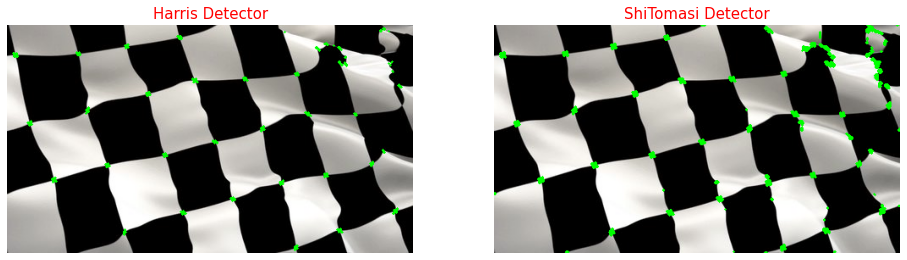

In [19]:
#   Visualizing image with marked corners
fig = plt.figure(figsize = (16, 10))
(ax1, ax2) = fig.subplots(1, 2)

#   Image with Harris method
ax1.imshow(mark_Harris, cmap = 'gray')
ax1.set_title('Harris Detector', c = 'r', fontsize = 15)
ax1.axis("off")

#   Image with ShiTomasi method
ax2.imshow(mark_ShiTomasi, cmap = 'gray')
ax2.set_title('ShiTomasi Detector', c = 'r', fontsize = 15)
ax2.axis("off");

In [ ]:
def visualize_lambda(M_elems):
    Sum_Ix2, Sum_Iy2, Sum_IxIy = M_elems

    m, n = Sum_Ix2.shape
    lambd_1 = np.zeros((m, n))
    lambd_2 = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            #    Computing for each point in image
            H = np.zeros((2, 2))
            H[0][0] = Sum_Ix2[i][j]
            H[0][1] = Sum_IxIy[i][j]
            H[1][0] = Sum_IxIy[i][j]
            H[1][1] = Sum_Iy2[i][j]
            #    Computing eigenvalues
            eigen_val, _ = np.linalg.eig(H)
            lambd_1[i][j] = eigen_val[0]
            lambd_2[i][j] = eigen_val[1]
    
    #   Normalizing R
    Norm_1 = lambd_1 / lambd_1.max()
    Norm_2 = lambd_2 / lambd_1.max()

    return Norm_1, Norm_2

In [ ]:
def visualize_lambda(M_elems):
    Sum_Ix2, Sum_Iy2, Sum_IxIy = M_elems

    m, n = Sum_Ix2.shape
    lambd_1 = np.zeros((m, n))
    lambd_2 = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            #    Computing for each point in image
            H = np.zeros((2, 2))
            H[0][0] = Sum_Ix2[i][j]
            H[0][1] = Sum_IxIy[i][j]
            H[1][0] = Sum_IxIy[i][j]
            H[1][1] = Sum_Iy2[i][j]
            #    Computing eigenvalues
            eigen_val, _ = np.linalg.eig(H)
            lambd_1[i][j] = eigen_val[0]
            lambd_2[i][j] = eigen_val[1]
    
    #   Normalizing R
    Norm_1 = lambd_1 / lambd_1.max()
    Norm_2 = lambd_2 / lambd_1.max()

    return Norm_1, Norm_2

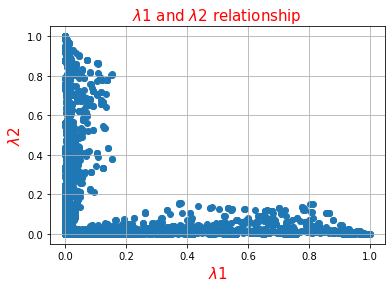

In [ ]:
lambda_1, lambda_2 = visualize_lambda(M_elements)
plt.scatter(lambda_1, lambda_2)
plt.xlabel("$\lambda 1$", fontsize = 15, c = 'r')
plt.ylabel("$\lambda 2$", fontsize = 15, c = 'r')
plt.title("$\lambda 1$ and $\lambda 2$ relationship ", fontsize = 15, c = 'r')
plt.grid()
plt.show()
plt.close()